# Fingerprints Quality Classification
## DNN Course JCE - Final Project 
### By Kobi Amsellem & Zohar Kedem

Expirements:
* Try to classify 5 classes that represat the quality of the finger print (0 poor, 4 best)

In [1]:
# Relevenat imports
import numpy as np
import tensorflow as tf
import seaborn as sn
from sklearn.metrics import confusion_matrix as confusion_mtrx
from keras import layers, Sequential
from keras.preprocessing.image import ImageDataGenerator
import pathlib
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, Nadam

**Hyperparameters**

In [2]:
# Fixed seed for split, shuffle and init
seed=9
# image height and width by avvrage dataset size
batch_size = 32
img_height = 180
img_width = 180

# splitting data ratio between train/test/val
train_split = 0.7
validation_split = 0.15
test_split = 0.15

# model hyperparameters
learning_rate = 0.001


**Loading data to train and validation tensors**

Total:  976  examples
Found 976 files belonging to 5 classes.
Metal device set to: AMD Radeon Pro 5500M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB

train 21
val 5
test 5


2022-02-03 14:48:24.436738: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-03 14:48:24.437629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-03 14:48:24.437966: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


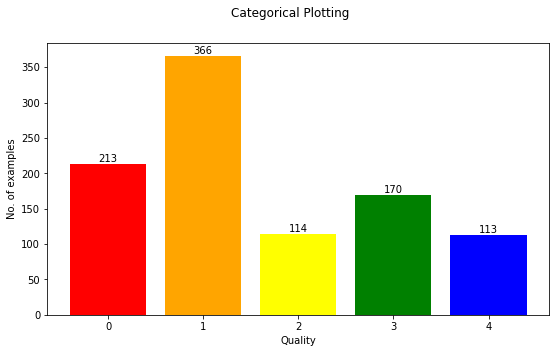

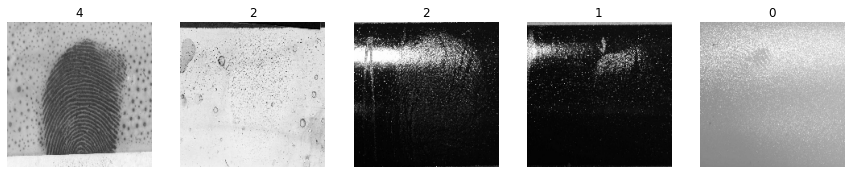

In [3]:
dirs = !ls Dataset

data_dir = pathlib.Path('./Dataset')
DATASET_SIZE = len(list(data_dir.glob('*/*.jpg')))
print('Total: ', DATASET_SIZE, ' examples')


counts = []
for dir in dirs:
  ddir = pathlib.Path('./Dataset/'+dir+'/')
  counts.append(len(list(ddir.glob('*.jpg'))))

fig, axs = plt.subplots(1, 1, figsize=(9, 5), sharey=True)
c = ['red', 'orange', 'yellow', 'green', 'blue']
axs.bar(dirs, counts, color=c)
axs.set_ylabel('No. of examples')
axs.set_xlabel('Quality')
axs.bar_label(axs.containers[0])
fig.suptitle('Categorical Plotting')

full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels='inferred',
  label_mode='categorical',
  )

train_size = int(train_split * (DATASET_SIZE/batch_size))
val_size = int(validation_split * (DATASET_SIZE/batch_size))
test_size = int(test_split * (DATASET_SIZE/batch_size))

full_dataset = full_dataset.shuffle(seed)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size+1)
test_dataset = test_dataset.take(test_size+1)

train_dataset = train_dataset
val_dataset = val_dataset
test_dataset = test_dataset


plt.figure(figsize=(15, 5))
for images, labels in train_dataset.take(1):
  for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(np.argmax(labels[i].numpy()))
    plt.axis("off")

**Data Augmentation**
Set sequential data augmentation pipeline:

* Random Rotation
* Random Flip
* Random Contrast

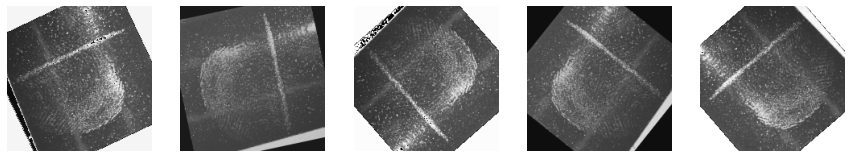

In [4]:
data_augmentation = Sequential()
data_augmentation.add(layers.RandomFlip(mode="horizontal_and_vertical", seed=seed))
data_augmentation.add(layers.RandomRotation((0,1),fill_mode="constant",interpolation="bilinear",seed=seed,fill_value=0.0))
data_augmentation.add(layers.RandomContrast(0.4, seed=None))

plt.figure(figsize=(15, 5))
with tf.device('/cpu:0'):
    for images, _ in train_dataset.take(1):
        for i in range(5):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(1, 5, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

In [5]:
fpq_model = Sequential(tf.keras.applications.EfficientNetB2(include_top=False,
# pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
)
for layer in fpq_model.layers:
        layer.trainable=False

# fpq_model.add(data_augmentation)


### Classification Layers ###



In [6]:
fc_classifier = Sequential()
fc_classifier.add(layers.Flatten())
fc_classifier.add(layers.Dense(512, activation='relu'))
fc_classifier.add(layers.Dropout(0.4))
# fc_classifier.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
fc_classifier.add(layers.Dense(128, activation='relu'))
fc_classifier.add(layers.Dropout(0.3))
fc_classifier.add(layers.Dense(32, activation='relu'))
fc_classifier.add(layers.Dropout(0.2))
fc_classifier.add(layers.Dense(5, activation='softmax'))



In [7]:
fpq_model.add(fc_classifier)
fpq_model.build((None, 180, 180, 3))
fpq_model.summary()
fpq_model.compile(optimizer=Nadam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history = fpq_model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 1408)             7768569   
                                                                 
 sequential_2 (Sequential)   (None, 5)                 791365    
                                                                 
Total params: 8,559,934
Trainable params: 791,365
Non-trainable params: 7,768,569
_________________________________________________________________
Epoch 1/10


/Users/kobiamsellem/tensorflow-metal/lib/python3.8/site-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)
2022-02-03 14:48:36.477783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 1.2806 - accuracy: 0.4821

2022-02-03 14:48:43.442671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 15s 342ms/step - loss: 1.2806 - accuracy: 0.4821 - val_loss: 0.9218 - val_accuracy: 0.6736
Epoch 2/10
21/21 [==============================] - 5s 207ms/step - loss: 0.9828 - accuracy: 0.6250 - val_loss: 0.8234 - val_accuracy: 0.7292
Epoch 3/10
21/21 [==============================] - 5s 208ms/step - loss: 0.8707 - accuracy: 0.6637 - val_loss: 0.7367 - val_accuracy: 0.7222
Epoch 4/10
21/21 [==============================] - 5s 209ms/step - loss: 0.8201 - accuracy: 0.6741 - val_loss: 0.6634 - val_accuracy: 0.7569
Epoch 5/10
21/21 [==============================] - 5s 211ms/step - loss: 0.6882 - accuracy: 0.7262 - val_loss: 0.5956 - val_accuracy: 0.7625
Epoch 6/10
21/21 [==============================] - 5s 213ms/step - loss: 0.6409 - accuracy: 0.7351 - val_loss: 0.5207 - val_accuracy: 0.7986
Epoch 7/10
21/21 [==============================] - 5s 212ms/step - loss: 0.6601 - accuracy: 0.7411 - val_loss: 0.5425 - val_accuracy: 0.7750
Epoch 8/10
21/21

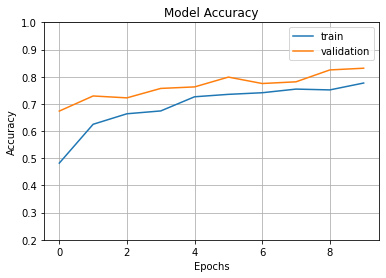

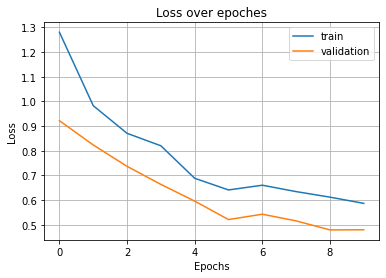

In [8]:
acc_history = history.history['accuracy']
val_acc_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

fig1 = plt.gcf()
plt.plot(acc_history)
plt.plot(val_acc_history)
plt.axis(ymin=0.2,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig1 = plt.gcf()
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.title('Loss over epoches')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### Confusion Metrix ###

2022-02-03 14:49:33.272923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


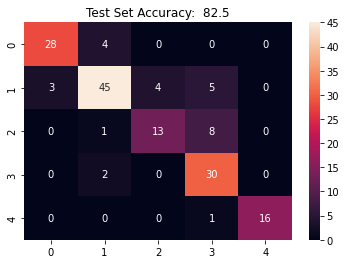

In [9]:

y_test = []
y_predict = []

for images, labels in test_dataset:
    tmp_predict = fpq_model.predict(images)
    tmp_true_max = np.argmax(labels.numpy(), axis=1).astype(np.uint8)
    tmp_pred_max = np.argmax(tmp_predict, axis=1).astype(np.uint8)
    y_test = [*y_test, *tmp_true_max]
    y_predict = [*y_predict, *tmp_pred_max]


cm = confusion_mtrx(y_test, y_predict)
sn.heatmap(cm ,annot = True)
acc = (np.array(y_test) == np.array(y_predict)).sum()/len(y_test)
plt.title("Test Set Accuracy:  "+str(round(acc*100, 2)))
plt.show()